In [1]:
# Read packedges

import pandas as pd
import pandas.testing as tm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.discrete.discrete_model as dm

from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa


from scipy.fft import fft, ifft, fftfreq

import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf

import itertools
from itertools import combinations, chain

from scipy.stats import pearsonr

import re

import functions

import early_warning_detection_functions

from datetime import datetime

import pymannkendall as mk

import math

import trend_timeseries

from scipy.stats import friedmanchisquare

from sklearn.metrics import r2_score

from pmdarima.preprocessing import FourierFeaturizer
from pmdarima.datasets import load_wineind
from sklearn.linear_model import LinearRegression


# Read processed data

In [2]:
df = pd.read_parquet('//home/juliane.oliveira/workspace/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_otc_phc_muni.parquet')



In [3]:
df.year_week.min()

'2022-47'

In [4]:
df = df.assign(phc_4_lag_0 = df.atend_ivas_4,
               otc_4_lag_0 = df.num_otc_ivas_4)

# Run regressions

## Early warning on OTC series with APS

### Cities without trend and sezonality

In [5]:
df.columns

Index(['sigla_uf', 'co_uf', 'nm_uf', 'co_ibge7', 'nm_municipio', 'co_ibge',
       'year_week', 'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end',
       'atend_ivas', 'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4',
       'dtrend_ivas_negbi', 'dtrend_otc_negbi', 'p_values_negbi_atend_ivas_4',
       'p_values_negbi_num_otc_ivas_4', 'p_value_ivas_negbi_friedman',
       'p_value_otc_negbi_friedman', 'phc_4_lag_1', 'phc_4_lag_2',
       'phc_4_lag_3', 'otc_4_lag_1', 'otc_4_lag_2', 'otc_4_lag_3',
       'phc_4_lag_0', 'otc_4_lag_0'],
      dtype='object')

In [7]:
# select cities without trend and sezonality in PHC

df1 = df[(df.p_value_otc_negbi_friedman >= 0.05) & (df.p_values_negbi_num_otc_ivas_4 >= 0.05)]

print('number of city without trend and sezonality', df1.co_ibge.nunique(), 'percentage', round(df1.co_ibge.nunique()*100/5570,1) )

number of city without trend and sezonality 2440 percentage 43.8


In [8]:
lags_y = range(1, 4)  # Example: Using lags 1 to 4 for y_t
lags_x = range(0, 4)  # Example: Using lags 0 to 4 for x_t
dependent_variable = 'num_otc_ivas_4'  # Example dependent variable

def lags_comb(variable, lags_variable):
    """Create cumulative lag combinations for a given variable."""
    lags_variable_comb = [f'{variable}_{lag}' for lag in lags_variable]
    cumulative_sums_var = [' + '.join(lags_variable_comb[:i]) for i in range(1, len(lags_variable_comb) + 1)]
    return cumulative_sums_var

# Generate lagged combinations
lags_y_comb = lags_comb('otc_4_lag', lags_y)
lags_x_comb = lags_comb('phc_4_lag', lags_x)

formulas = []

# Iterate over all combinations and create formula strings
for value in lags_x_comb:
    for terms in lags_y_comb:
        components = [terms, value]
        # Remove empty strings and join components
        formula_components = ' + '.join(filter(None, components))
        formula = f'{dependent_variable} ~ {formula_components}'
        formulas.append(formula)

In [10]:
## Keep the best model formulas and AIC

lst = []

for code in df1.co_ibge.unique():

    #print(code)

    data = df1[df1.co_ibge == code]

    # Placeholder for the best model
    best_model = None
    best_aic = float('inf')
    best_formula = None

    # Loop through all formulas to find the best model based on AIC
    for formula in formulas:
        
        # Fit the model
        alpha = 1
        model = smf.glm(formula=formula, data=data, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
        
        # Check the AIC of the current model
        current_aic = model.aic
        
        # Update the best model if the current model has a lower AIC
        if current_aic < best_aic:
            best_aic = current_aic
            best_model = model
            best_formula = formula

    data = data.assign(best_formula = best_formula)
    data = data.assign(best_aic = best_aic)
    
    lst.append(data)

lst_dfs_cities1 = lst



#### save predicted values, upperbound and warning columns

# we know the best model that adjust to the data of each municipality. Thus:

lst = []

for data in lst_dfs_cities1:
    # Fit the model
    alpha = 1
    model = smf.glm(formula=data.best_formula.iloc[0], data=data, family=sm.families.NegativeBinomial(alpha=alpha)).fit()

    # Extract fitted values and residuals
    fitted_values = model.fittedvalues
    residuals = model.resid_deviance
    
    sigma = np.std(residuals)
    sigma_ = np.std(fitted_values)
    sigma_t = fitted_values.rolling(window=5).std()
    
    data = data.assign(fitted_values_otc_only = fitted_values,
                      residuals_otc_only = residuals,
                      sigma_otc_only = sigma,
                      sigma__otc_only = sigma_,
                      sigma_t_otc_only = sigma_t)
    
    lst.append(data)
    
lst_dfs_cities1 = lst


lst = []
for i in range(len(lst_dfs_cities1)):
    
    data = lst_dfs_cities1[i]
    
    # Calculate control limits for the original series
    w = 1 #data.w_best.iloc[0]
    
    data = data.assign(UCL_otc_only = data.fitted_values_otc_only + w * data.sigma_t_otc_only,
                      LCL_otc_only = data.fitted_values_otc_only - w * data.sigma_t_otc_only)

    data = data.assign(out_of_limits_above_otc_only = (data['num_otc_ivas_4'] >= data.UCL_otc_only).astype(int),
                       out_of_limits_below_otc_only = (data['num_otc_ivas_4'] < data.LCL_otc_only).astype(int)
                       )
    
    lst.append(data)
    
lst_dfs_cities1 = lst   

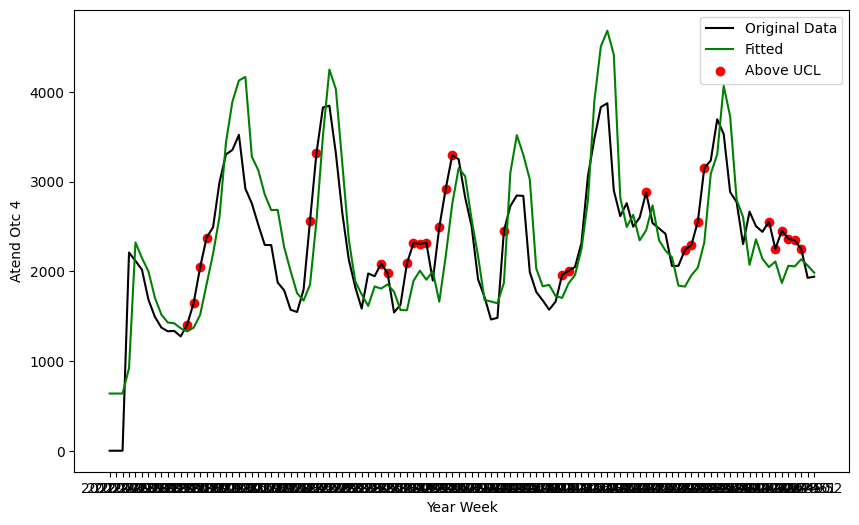

In [11]:
dta = lst_dfs_cities1[0]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(dta.year_week, dta['num_otc_ivas_4'], label='Original Data', color='black')
# Plot the original data
plt.plot(dta.year_week, dta['fitted_values_otc_only'], label='Fitted', color='green')

# Create boolean masks for points outside limits
out_of_limits_above = dta['num_otc_ivas_4'] >= dta['UCL_otc_only']
out_of_limits_below = dta['num_otc_ivas_4'] < dta['LCL_otc_only']

# Scatter plot for points above UCL
plt.scatter(
    dta['year_week'][out_of_limits_above],  # Ensure the index aligns
    dta['num_otc_ivas_4'][out_of_limits_above],  # Use the same DataFrame
    color='red',
    label='Above UCL'
)

# Optional: Scatter plot for points below LCL
#plt.scatter(
#    dta['year_week'][out_of_limits_below],
#    dta['atend_ivas_4'][out_of_limits_below],
#   color='blue',
#    label='Below LCL'
#)

# Add labels and legend
plt.xlabel('Year Week')
plt.ylabel('Atend Otc 4')
plt.legend()
plt.show()


### Cities with trend and without sezonality

In [12]:
# select cities without trend and sezonality in PHC

df2 = df[(df.p_value_otc_negbi_friedman >= 0.05) & (df.p_values_negbi_num_otc_ivas_4 < 0.05)]

print('number of city with trend and without sezonality', df2.co_ibge.nunique(), 'percentage', round(df2.co_ibge.nunique()*100/5570,1) )

number of city with trend and without sezonality 1328 percentage 23.8


In [13]:
lags_y = range(1, 4)  # Example: Using lags 1 to 4 for y_t
lags_x = range(0, 4)  # Example: Using lags 0 to 4 for x_t
dependent_variable = 'num_otc_ivas_4'  # Example dependent variable

def lags_comb(variable, lags_variable):
    """Create cumulative lag combinations for a given variable."""
    lags_variable_comb = [f'{variable}_{lag}' for lag in lags_variable]
    cumulative_sums_var = [' + '.join(lags_variable_comb[:i]) for i in range(1, len(lags_variable_comb) + 1)]
    return cumulative_sums_var

# Generate lagged combinations
lags_y_comb = lags_comb('otc_4_lag', lags_y)
lags_x_comb = lags_comb('phc_4_lag', lags_x)

formulas = []

# Iterate over all combinations and create formula strings
for value in lags_x_comb:
    for terms in lags_y_comb:
        components = [terms, value]
        # Remove empty strings and join components
        formula_components = 'time_trend + ' + ' + '.join(filter(None, components))
        formula = f'{dependent_variable} ~ {formula_components}'
        formulas.append(formula)

In [15]:
## Keep the best model formulas and AIC
lst = []

for code in df2.co_ibge.unique():
    print(f"Processing {code}...")

    data = df2[df2.co_ibge == code].copy()
    data = data.assign(time_trend=np.arange(len(data)))

    # Initialize placeholders
    best_model = None
    best_aic = float('inf')
    best_formula = np.nan  # Set default as NaN

    # Try fitting models
    for formula in formulas:
        try:
            model = smf.glm(formula=formula, data=data, family=sm.families.NegativeBinomial(alpha=1)).fit()
            current_aic = model.aic

            if current_aic < best_aic:
                best_aic = current_aic
                best_model = model
                best_formula = formula

        except Exception as e:
            print(f"Skipping formula {formula} for {code}: {e}")
            continue  # Skip to the next formula

    # Assign best formula and AIC (or NaN if model failed)
    data = data.assign(best_formula=best_formula, best_aic=best_aic if best_aic != float('inf') else np.nan)
    lst.append(data)

lst_dfs_cities2 = lst  # Store results

#### Save predicted values, upper bound, and warning columns

lst = []

for data in lst_dfs_cities2:
    
    if pd.isna(data.best_formula.iloc[0]):
        # If no valid model, create NaN columns
        data = data.assign(
                fitted_values_otc_only=np.nan,
                residuals_otc_only=np.nan,
                sigma_otc_only=np.nan,
                sigma__otc_only=np.nan,
                sigma_t_otc_only=np.nan
            )
    else:
        # Fit the model and calculate residuals
        model = smf.glm(formula=data.best_formula.iloc[0], data=data, family=sm.families.NegativeBinomial(alpha=1)).fit()
        fitted_values = model.fittedvalues
        residuals = model.resid_deviance

        # Calculate sigmas
        sigma = np.std(residuals)
        sigma_ = np.std(fitted_values)
        sigma_t = fitted_values.rolling(window=5).std()

        # Assign values
        data = data.assign(
                fitted_values_otc_only=fitted_values,
                residuals_otc_only=residuals,
                sigma_otc_only=sigma,
                sigma__otc_only=sigma_,
                sigma_t_otc_only=sigma_t
            )

    lst.append(data)

lst_dfs_cities2 = lst  # Store results

### Control limits and out-of-limits detection

lst = []

for data in lst_dfs_cities2:
    
    if data['fitted_values_otc_only'].isna().all():
        # If no valid fitted values, assign NaNs
        data = data.assign(
                    UCL_otc_only=np.nan,
                    LCL_otc_only=np.nan,
                    out_of_limits_above_otc_only=np.nan,
                    out_of_limits_below_otc_only=np.nan
            )
    else:
        w = 1  # Default weight
        
        UCL_otc_only = data.fitted_values_otc_only + w * data.sigma_t_otc_only
        LCL_otc_only = data.fitted_values_otc_only - w * data.sigma_t_otc_only
        
        data = data.assign(
                UCL_otc_only =  UCL_otc_only,
                LCL_otc_only =  LCL_otc_only,
                out_of_limits_above_otc_only = (data['num_otc_ivas_4'] >= UCL_otc_only).astype(int),
                out_of_limits_below_otc_only=(data['num_otc_ivas_4'] < LCL_otc_only).astype(int)
            )

    lst.append(data)

lst_dfs_cities2 = lst  # Store final results


Processing 110146...
Processing 130115...
Processing 130420...
Processing 150013...
Processing 150450...
Processing 150810...
Processing 170105...
Processing 170290...
Processing 171880...
Processing 210825...
Processing 211163...
Processing 211178...
Processing 220110...
Processing 220553...
Processing 231090...
Processing 231335...
Processing 240080...
Processing 240320...
Processing 240620...
Processing 250010...
Processing 250220...
Processing 250870...
Processing 251070...
Processing 251220...
Processing 261500...
Processing 280250...
Processing 290560...
Processing 291685...
Processing 291900...
Processing 292390...
Processing 292467...
Processing 292550...
Processing 292975...
Processing 310330...
Processing 310590...
Processing 312870...
Processing 314053...
Processing 316443...
Processing 316960...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 316960: NaN, inf or invalid value detected in weights, estimation infeasible

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.en

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 316960: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 316960: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 320035...
Processing 350720...
Processing 353360...
Processing 353520...
Processing 354070...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 354070: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 354070: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 354070: NaN, inf or invalid va

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 411590...
Processing 420205...
Processing 420215...
Processing 421003...
Processing 421280...
Processing 430905...
Processing 431545...
Processing 431755...
Processing 431830...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 431830: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 431830: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 431830: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 431830: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/stat

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 431830: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 510618...
Processing 520450...
Processing 520690...
Processing 140010...
Processing 150430...
Processing 170710...
Processing 171610...
Processing 171670...
Processing 171840...
Processing 171888...
Processing 210430...
Processing 210590...
Processing 220117...
Processing 220225...
Processing 220230...
Processing 220385...
Processing 220490...
Processing 220660...
Processing 230535...
Processing 231180...
Processing 240350...
Processing 240770...
Processing 240920...
Processing 241470...
Processing 250940...
Processing 251190...
Processing 261520...
Processing 270490...
Processing 290150...
Processing 291230...
Processing 291270...
Processing 291660...
Processing 311783...
Processing 312860...
Processing 313040...
Processing 313760...
Skipping formula nu

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/p

Processing 315390...
Processing 350070...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 350070: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 350070: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 350070: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 350070: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 350070: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 350070: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 350070: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 350130...
Processing 350520...
Processing 350700...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 350700: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 350700: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 350700: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 351050...
Processing 352460...
Processing 352490...
Processing 354050...
Processing 355390...
Processing 410405...
Processing 412230...
Processing 420590...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 420590: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 420590: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 420590: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 420590: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 420670...
Processing 421505...
Processing 430558...
Processing 430675...
Processing 431710...
Processing 431770...
Processing 432060...
Processing 432234...
Processing 510626...
Processing 110014...
Processing 150100...
Processing 150442...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 150442: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 150442: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 150442: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 150442: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 150442: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 210173...
Processing 220455...
Processing 220557...
Processing 220560...
Processing 231123...
Processing 240050...
Processing 240140...
Processing 251560...
Processing 260060...
Processing 270050...
Processing 280200...
Processing 290570...
Processing 291050...
Processing 291130...
Processing 291670...
Processing 292010...
Processing 293250...
Processing

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 312410: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 313320...
Processing 314020...
Processing 314480...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 314480: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 314480: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 314970...


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 316070...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 316070: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/stat

Processing 316180...
Processing 330550...
Processing 351519...
Processing 352290...
Processing 352520...
Processing 353390...
Processing 353620...
Processing 354060...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 354060: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 354060: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 354060: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 354060: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 354060: NaN, inf or invalid value detected in weigh

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.en

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 354060: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 354060: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 354120...
Processing 354640...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 354640: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 354640: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 354640: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formul

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 354640: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 354640: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 355100...
Processing 411710...
Processing 420300...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 420300: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 420300: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 431036...
Processing 431446...
Processing 432183...
Processing 432370...
Processing 120020...
Processing 120033...
Processing 130395...
Processing 150400...
Processing 150660...
Processing 170270...
Processing 170386...
Processing 210125...
Processing 210390...
Processing 210840...
Processing 210980...
Processing 220275...
Processing 230426...
Processing 230470...
Processing 240310...
Processing 240410...
Processing 240485...
Processing 240933...
Processing 251260...
Processing 260845...
Processing 290770...
Processing 291710...
Processing 291733...
Processing 292980...
Processing 311420...
Processing 313070...
Processing 315360...
Processing 316540...
Processing 320090...
Processing 320210...
Processing 351510...
Skipping formula num_otc_ivas_4 ~ time_t

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages

Processing 352560...
Processing 352750...
Processing 353110...
Processing 353120...
Processing 354220...
Processing 411380...
Processing 411925...
Processing 420070...
Processing 420110...
Processing 421440...
Processing 422000...
Processing 430205...
Processing 430517...
Processing 430593...
Processing 431237...
Processing 431306...
Processing 432190...
Processing 432300...
Processing 510260...
Processing 510523...
Processing 510890...
Processing 520310...
Processing 520340...
Processing 522045...
Processing 110180...
Processing 120034...
Processing 130390...
Processing 130426...
Processing 150175...
Processing 150520...
Processing 150611...
Processing 150750...
Processing 170255...
Processing 171525...
Processing 210740...
Processing 211172...
Processing 220750...
Processing 220900...
Processing 220955...
Processing 230427...
Processing 231000...
Processing 240520...
Processing 241050...
Processing 241310...
Processing 250300...
Processing 251396...
Processing 261310...
Processing 26

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/stat

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 314280: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 314280: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 314280: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 314280: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 314280: NaN, inf or invalid value det

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.en

Processing 354280...
Processing 354610...
Processing 354930...
Processing 411120...
Processing 411460...
Processing 411573...
Processing 411760...
Processing 421200...
Processing 421507...
Processing 421560...
Processing 432215...
Processing 510624...
Processing 510820...
Processing 521470...
Processing 522070...
Processing 120043...
Processing 130120...
Processing 130353...
Processing 150260...
Processing 150275...
Processing 150490...
Processing 150616...
Processing 160021...
Processing 170215...
Processing 171780...
Processing 172110...
Processing 210500...
Processing 211102...
Processing 220710...
Processing 221038...
Processing 230170...
Processing 230190...
Processing 230428...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 230428: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/stat

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 230428: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 230428: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 230428: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 230428: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 240580...


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.en

Processing 240650...
Processing 241170...
Processing 241260...
Processing 251170...
Processing 251278...
Processing 251570...
Processing 260980...
Processing 270380...
Processing 291110...
Processing 293140...
Processing 293160...
Processing 310060...
Processing 311850...
Processing 312510...
Processing 312980...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 312980: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 312980: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 312980: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 313510...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 313510: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 313510: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 313510: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 313510: NaN, inf or invalid v

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 313820...
Processing 314370...
Processing 314620...
Processing 314940...
Processing 315765...
Processing 315895...


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.en

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 315895: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 317140...
Processing 350275...
Processing 350280...
Processing 350530...


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.en

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 350530: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 350530: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 350530: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 350530: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 350530: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formul

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 420140: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 420230...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 420230: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 420230: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 420230: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 420230: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 420230: NaN, in

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/stat

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 420230: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 420230: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 420230: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 421225...
Processing 430175...
Processing 430890...
Processing 431800...
Processing 510020...
Processing 510250...
Processing 520460...
Processing 521000...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 521000: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 110148...
Processing 120032...
Processing 130006...
Processing 130060...
Processing 150530...
Processing 210375...
Processing 211020...
Processing 211085...
Processing 220460...
Processing 220950...
Processing 230393...
Processing 231410...
Processing 240060...
Processing 240270...
Processing 240740...
Processing 241040...
Processing 250905...
Processing 260780...
Processing 270020...
Processing 270120...
Processing 270140...
Processing 270710...
Processing 280320...
Processing 280700...
Processing 290510...
Processing 291380...
Processing 291530...
Processing 291640...
Processing 291990...
Processing 311600...
Processing 312790...
Processing 313180...
Processing 314290...
Processing 316820...
Processing 320200...
Processing 350150...
Processing 351330...
Processing 351740...
Processing 351800...
Processing 352910...
Processing 411850...
Processing 412627...
Processing 412788...
Processing 420075...
Processing 430790...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_la

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 510268...
Processing 520630...
Processing 522015...
Processing 522026...
Processing 110013...
Processing 110032...
Processing 140040...
Processing 150650...
Processing 160027...
Processing 170300...
Processing 170510...
Processing 171550...
Processing 210290...
Processing 210320...
Processing 210547...
Processing 220005...
Processing 220090...
Processing 220300...
Processing 220997...
Processing 231010...
Processing 240160...
Processing 240190...
Processing 240280...
Processing 240360...
Processing 240870...
Processing 240880...
Processing 240950...
Processing 241350...
Processing 250190...
Processing 250530...
Processing 250550...
Processing 251460...
Processing 251590...
Processing 261130...
Processing 261340...
Processing 270870...
Processing 291820...
Processing 292905...
Processing 292970...
Processing 293270...
Processing 311650...
Processing 312260...
Processing 314590...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 314590: NaN, inf or 

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 314590: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 314590: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 314590: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 314700...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 314700: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 314700: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_o

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-p

Processing 316090...
Processing 316557...
Processing 350140...
Processing 350360...
Processing 350535...
Processing 351480...
Processing 351700...
Processing 351860...
Processing 353230...
Processing 354460...
Processing 354700...
Processing 412010...
Processing 412635...
Processing 420370...
Processing 420410...
Processing 431455...
Processing 500025...
Processing 521160...
Processing 110090...
Processing 120060...
Processing 120080...
Processing 130070...
Processing 130356...
Processing 130423...
Processing 140005...
Processing 150280...
Processing 150549...
Processing 170380...
Processing 170825...
Processing 171240...
Processing 171500...
Processing 171665...
Processing 210083...
Processing 210490...
Processing 210637...
Processing 210760...
Processing 211227...
Processing 230195...
Processing 240145...
Processing 240340...
Processing 241290...
Processing 250150...
Processing 250360...
Processing 251398...
Processing 251500...
Processing 251675...
Processing 260070...
Processing 26

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 280160...
Processing 290310...
Processing 290940...
Processing 311560...
Processing 312460...
Processing 313390...
Processing 313440...
Processing 314200...


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 314200: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 314200: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 314420...
Processing 315040...
Processing 316470...
Processing 317005...
Processing 317150...
Processing 330020...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 330020: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 330020: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(m

Processing 351610...
Processing 352215...
Processing 352800...
Processing 354010...
Processing 355050...
Processing 355670...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 355670: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 355670: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 355670: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 355670: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/st

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 355670: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 355670: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 410712...
Processing 420208...
Processing 420315...
Processing 430165...
Processing 430760...
Processing 520280...
Processing 520860...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 520860: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 520860: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 520860: NaN, inf or invalid value detected i

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 521830...
Processing 521878...
Processing 120010...
Processing 130360...
Processing 170030...
Processing 171070...
Processing 171630...
Processing 220100...
Processing 220735...
Processing 220965...
Processing 221095...
Processing 230220...
Processing 230945...
Processing 240250...
Processing 240460...
Processing 250157...
Processing 250570...
Processing 251040...
Processing 251410...
Processing 270135...
Processing 270470...
Processing 270590...
Processing 270850...
Processing 280340...
Processing 291855...
Processing 293000...
Processing 310260...
Processing 311800...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 311800: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 311800: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 +

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/stat

Processing 312600...
Processing 312825...
Processing 330380...
Processing 350380...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 350380: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 351220...
Processing 351925...
Processing 352140...
Processing 352400...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 352400: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 352400: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 352400: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 352400: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 352400: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 352400: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 410045...
Processing 411320...
Processing 412240...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 412240: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 420500...
Processing 421000...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 421000: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2


Processing 431175...
Processing 431210...
Processing 431975...
Processing 110018...
Processing 120013...
Processing 130230...
Processing 130250...
Processing 150110...
Processing 150380...
Processing 170100...
Processing 210317...
Processing 210592...
Processing 210810...
Processing 220202...
Processing 220310...
Processing 220400...
Processing 220450...
Processing 220779...
Processing 230790...
Processing 240400...
Processing 240680...
Processing 241110...
Processing 250160...
Processing 250880...
Processing 251065...
Processing 251540...
Processing 260490...
Processing 261190...
Processing 290060...
Processing 290115...
Processing 290190...
Processing 292420...
Processing 292510...
Processing 310740...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 310740: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 311010...
Processing 311020...
Processing 312380...
Processing 313680...
Processing 350250...
Processing 350840...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 350840: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 350840: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 350840: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 350840: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 350840: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 351470...
Processing 352180...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 352180: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.en

Processing 352550...
Processing 352860...
Processing 353600...
Processing 355550...
Processing 411790...
Processing 412520...
Processing 420543...
Processing 421010...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 421010: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 421010: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 421010: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 421010: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 421010: NaN, inf or inv

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/s

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 421010: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 421010: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 421010: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 430693...
Processing 431046...
Processing 520055...
Processing 520396...
Processing 520400...
Processing 521090...
Processing 522000...
Processing 120005...
Processing 120050...
Processing 130220...
Processing 130400...
Processing 150506...
Processing 150555...
Processing 171870...
Processing 171886...
Processing 210087...
Processing 210255...
Processing

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/

Processing 351830...
Processing 351885...
Processing 351960...
Processing 352040...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 352040: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 352040: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 352040: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 352200...


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 352960...
Processing 352980...
Processing 353325...
Processing 410425...
Processing 411740...
Processing 412135...
Processing 412220...
Processing 420055...
Processing 420945...
Processing 421740...
Processing 430045...
Processing 430800...
Processing 431642...
Processing 510345...
Processing 520590...
Processing 110001...
Processing 110170...
Processing 120017...
Processing 130180...
Processing 140030...
Processing 150210...
Processing 150808...
Processing 210235...
Processing 210580...
Processing 210596...
Processing 211150...
Processing 211157...
Processing 221040...
Processing 231130...


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 231130: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 231130: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 231130: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 231130: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 231130: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/stat

Processing 311250...
Processing 312010...
Processing 312480...
Processing 313110...
Processing 313700...
Processing 313840...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 313840: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 313840: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 313840: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 313840: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.en

Processing 316290...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 316290: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 316290: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 316290: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 316290: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 316290: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.en

Processing 316300...
Processing 316930...
Processing 317110...
Processing 317190...
Processing 320316...
Processing 351385...
Processing 351410...


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/sit

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 351410: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 351410: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 352000...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 352000: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 352000: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 352000: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 352000: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 352000: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 352000: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 353340...
Processing 353370...
Processing 354150...
Processing 355720...
Processing 411125...
Processing 412500...
Processing 420395...
Processing 420510...
Processing 421040...
Processing 421590...
Processing 421630...
Processing 421860...
Processing 430469...
Processing 431390...
Processing 432225...
Processing 510525...
Processing 510619...
Processing 520355...
Processing 520380...
Processing 110029...
Pro

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 292340...
Processing 310890...
Processing 313150...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 313150: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 313150: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Processing 313790...
Processing 315120...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 315120: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 315120: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 315120: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 315120: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 315120: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 315120: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 315620...
Processing 351015...
Processing 352090...
Processing 353030...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 353030: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 353030: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 353030: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 353030: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 353030: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 353030: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 353730...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 353730: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 353730: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 353730: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 354000...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 354000: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 354000: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 354000: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 354000: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 354000: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/p

Processing 354105...
Processing 411900...
Processing 412020...
Processing 420710...
Processing 430155...
Processing 431217...
Processing 432285...
Processing 510420...
Processing 510685...
Processing 520945...
Processing 110155...
Processing 130195...
Processing 130240...
Processing 150495...
Processing 150795...
Processing 160040...
Processing 170230...
Processing 170330...
Processing 171180...
Processing 230290...
Processing 231340...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 231340: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages

Processing 251593...
Processing 260080...
Processing 260345...
Processing 270080...
Processing 280680...
Processing 290485...
Processing 291840...
Processing 292320...
Processing 292595...
Processing 311590...
Processing 312520...
Processing 313655...
Processing 314055...
Processing 314435...
Processing 316690...
Processing 317120...
Processing 330095...
Processing 350335...
Processing 350980...
Processing 351910...
Processing 352730...
Processing 353190...
Processing 354290...
Processing 354480...
Processing 354710...
Processing 411965...
Processing 412385...
Processing 412820...


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 412820: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 412820: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 412820: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 412820: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 412820: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 430057...
Processing 430210...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 430210: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 430210: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 430210: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/stat

Processing 430465...
Processing 431164...
Processing 431240...


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 431240: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 431240: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 431240: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 431240: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 431240: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 431240: NaN, inf or in

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 231050...
Processing 240290...
Processing 240690...
Processing 241360...
Processing 250403...
Processing 250450...
Processing 250720...
Processing 250950...
Processing 251380...
Processing 251720...
Processing 260940...
Processing 270740...
Processing 292090...
Processing 292205...
Processing 310500...
Processing 311830...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 311830: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 311830: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 311830: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packag

Processing 312290...
Processing 312530...
Processing 312960...
Processing 313720...
Processing 313867...
Processing 313925...
Processing 314150...
Processing 315053...
Processing 315737...
Processing 330260...
Processing 350510...
Processing 350970...
Processing 351090...
Processing 351140...
Processing 355010...
Processing 355300...


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 355300: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 411295...
Processing 420195...
Processing 421125...
Processing 430595...
Processing 430645...
Processing 430930...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 430930: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 430930: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 430930: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 430930: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 500345...
Processing 500500...
Processing 520420...
Processing 110033...
Processing 110143...
Processing 120070...
Processing 130040...
Processing 150340...
Processing 150835...
Processing 160020...
Processing 170730...
Processing 210409...
Processing 210465...
Processing 210710...
Processing 210920...
Processing 230130...
Processing 240185...
Processing 240660...
Processing 240780...
Processing 241060...
Processing 241330...
Processing 250580...
Processing 260550...
Processing 270150...
Processing 290440...
Processing 291005...


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 291005: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 291005: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 291005: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 291005: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 291005: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 291920: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 291920: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 291920: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 291920: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 292280...
Processing 292925...
Processing 293015...
Processing 310520...
Processing 310880...
Processing 311455...
Processing 312060...
Processing 312090...
Skipping formula num_otc_ivas_

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/stat

Processing 314130...
Processing 314810...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 314810: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 314810: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 314810: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 314810: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 314810: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/stat

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 314810: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 314810: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 314810: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 314850...
Processing 314880...
Processing 315160...
Processing 315415...
Processing 315860...
Processing 317052...
Processing 317130...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 317130: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/st

Processing 350680...
Processing 350920...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 350920: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 350920: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 350920: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 350920: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 350920: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 351040: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 351040: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 353286...
Processing 353880...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 353880: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 353880: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 353880: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 353880: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 353880: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 353880: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 354840...
Processing 355600...
Processing 410105...
Processing 410715...
Processing 411005...
Processing 411070...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 411070: NaN, inf or invalid value detected in weights, estimation

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/stat

Processing 420207...
Processing 421410...
Processing 421725...
Processing 430350...
Processing 430500...
Processing 430543...
Processing 430583...
Processing 430965...
Processing 431720...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 431720: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 431720: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 431720: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 431720: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 431720: NaN, inf or invalid va

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-p

Processing 510170...
Processing 510180...
Processing 510336...
Processing 520915...
Processing 521080...
Processing 521310...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 521310: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 521310: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 521310: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 521310: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 521310: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formul

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 521310: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 521310: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 521900...
Processing 522145...
Processing 110034...
Processing 130370...
Processing 150540...
Processing 150747...
Processing 171215...
Processing 171360...
Processing 211027...
Processing 220130...
Processing 220665...
Processing 230526...
Processing 240630...
Processing 241140...
Processing 250410...
Processing 260690...
Processing 270350...
Processing 270375...
Processing 270915...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 270915: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping f

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 280510...
Processing 280670...
Processing 290140...
Processing 291870...
Processing 313530...
Processing 314390...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 314390: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 314390: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 314390: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 314930...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 314930: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 314930: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 314930: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 314930: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 314930: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 3

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/stat

Processing 316780...
Processing 320300...
Processing 330210...
Processing 330290...
Processing 350170...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 350170: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 350170: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/s

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 350170: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 350170: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 350790...
Processing 350830...
Processing 351940...
Processing 352470...
Processing 352880...
Processing 353550...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 353550: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 353550: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 353550: NaN, inf or invalid value detected in weights, estimation

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/stat

Processing 411580...
Processing 420380...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 420380: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 420380: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 420380: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 420380: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 420380: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 420380: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 420380: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.en

Processing 230445...
Processing 230655...
Processing 231030...
Processing 240895...
Processing 240960...
Processing 241090...
Processing 250320...
Processing 251275...
Processing 251490...
Processing 260825...
Processing 270110...
Processing 270610...
Processing 280640...
Processing 290090...
Processing 292935...
Processing 293030...
Processing 293345...
Processing 310100...
Processing 310855...
Processing 313290...
Processing 314570...
Processing 315110...
Processing 316460...
Processing 317040...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 317040: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 317040: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 317040: NaN, inf or invalid value detected in weights, estimation i

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/stat

Processing 350590...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 350590: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 350590: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 350590: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 350590: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 350590: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 3

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 351280: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 352350...
Processing 353215...
Processing 353220...
Processing 355370...
Processing 355660...
Processing 412030...
Processing 420415...
Processing 421715...
Processing 421930...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 421930: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 421930: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 421930: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 421930: NaN, inf

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.en

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 421930: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 421930: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 421930: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 430440...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 430440: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 430440: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_o

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/p

Processing 430467...
Processing 430470...
Processing 430910...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 430910: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 430910: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 430910: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 431043...
Processing 431198...
Processing 431442...
Processing 431478...
Processing 431532...
Processing 431550...
Processing 431990...


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 431990: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 431990: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 431990: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 431990: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 431990: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 431990: NaN, inf or in

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 521975: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 521975: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 521975: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 521975: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 521975: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 521975: NaN, inf or in

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.en

Processing 310810...
Processing 311490...
Processing 313140...
Processing 313220...
Processing 314440...
Processing 314520...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 314520: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Processing 316850...
Processing 330520...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 330520: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 330520: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 330520: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 330520: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 330520: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 330520: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 330520: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 350060...
Processing 350730...
Processing 350925...
Processing 351540...
Processing 353530...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 353530: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 353530: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 353530: NaN, inf or invalid va

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/sit

Processing 353625...
Processing 354110...
Processing 354400...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 354400: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 354400: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 354400: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 354400: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 354515...
Processing 354800...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 354800: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.en

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 354800: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 354800: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 354800: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 355120...
Processing 355460...
Processing 410910...
Processing 411727...
Processing 420209...
Processing 421130...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 421130: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 421130: NaN, inf or inv

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/

Processing 430223...
Processing 430635...
Processing 432143...
Processing 520640...
Processing 522108...
Processing 110009...
Processing 130100...
Processing 150195...
Processing 150620...
Processing 172010...
Processing 210990...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 210990: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 210990: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 210990: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 210990: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/stat

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 210990: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 210990: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 220255...
Processing 220271...
Processing 220755...
Processing 221097...
Processing 240370...
Processing 240820...
Processing 241240...
Processing 241255...
Processing 241270...
Processing 251510...
Processing 260270...
Processing 260415...
Processing 260480...
Processing 261170...
Processing 261630...
Processing 270180...
Processing 270910...
Processing 292260...
Processing 293105...
Processing 312015...
Processing 312470...
Processing 313450...
Processing 315010...
Processing 315230...
Processing 316770...
Processing 350395...
Processing 350630.

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 355380...
Processing 410670...
Processing 411960...
Processing 420165...
Processing 430544...
Processing 431242...
Processing 431261...
Processing 500310...
Processing 510395...
Processing 150020...
Processing 150730...
Processing 150746...
Processing 170650...
Processing 170820...
Processing 210005...
Processing 210540...
Processing 210910...
Processing 210970...
Processing 210975...
Processing 211223...
Processing 211240...
Processing 220556...
Processing 230565...
Processing 230620...
Processing 240070...
Processing 241370...
Processing 250180...
Processing 251160...
Processing 251597...
Processing 260670...
Processing 260830...
Processing 270930...
Processing 290320...
Processing 290480...
Processing 291800...
Processing 291905...
Processing 310160...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 310160: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_l

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-p

Processing 311320...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 311320: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 311320: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 311320: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 312500...
Processing 313610...
Processing 315790...
Processing 316940...
Processing 352044...
Processing 353690...
Processing 354170...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 354170: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 354170: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 354170: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 354170: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 354170: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 354170: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 354740...
Processing 355395...
Processing 410260...
Processing 412640...
Processing 420270...
Processing 430430...
Processing 430585...
Processing 430830...
Pr

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.en

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 291955: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 291955: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 291955: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 291955: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 291955: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formul

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-p

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 313940: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 313940: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 314170...
Processing 315250...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 315250: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 315250: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 315250: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 320265...
Processing 330023...


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.en

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 330023: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 330023: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 330610...
Processing 351520...
Processing 351660...
Processing 351720...
Processing 351850...
Processing 351990...
Processing 354030...
Processing 410185...
Processing 421265...
Processing 430190...
Processing 430537...
Processing 430955...
Processing 431275...
Processing 432055...
Processing 432100...
Processing 432335...
Processing 500750...
Processing 510360...
Processing 522200...


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 522200: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 522200: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 522200: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 522205...
Processing 522230...
Processing 120001...
Processing 130160...
Processing 140045...
Processing 150050...
Processing 150497...
Processing 171650...
Processing 171884...
Processing 211280...
Processing 220177...
Processing 220770...
Processing 230523...
Processing 230880...
Processing 230970...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 240325...
Processing 240850...
Processing 241320...
Processing 241390...
Processing 250170...
Processing 260105...
Processing 260440...
Processing 261380...
Processing 270520...
Processing 270690...
Processing 291185...
Processing 310900...
Processing 311430...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 311430: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 311430: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 311430: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 311430: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 311430: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 311430: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 311430: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 312280...
Processing 314587...
Processing 315440...
Processing 315733...
Processing 330430...
Processing 351440...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 for 351440: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages

Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 351440: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 353020...
Processing 354900...
Processing 355540...
Processing 412620...
Processing 420120...
Processing 420760...
Processing 420765...
Processing 421625...
Processing 421755...
Processing 421960...
Processing 430435...
Processing 431140...
Processing 432035...
Processing 432195...
Processing 432250...
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 432250: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 432250: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 432250: NaN, inf or invalid value detected in

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 500480...
Processing 510700...
Processing 510792...
Processing 521890...


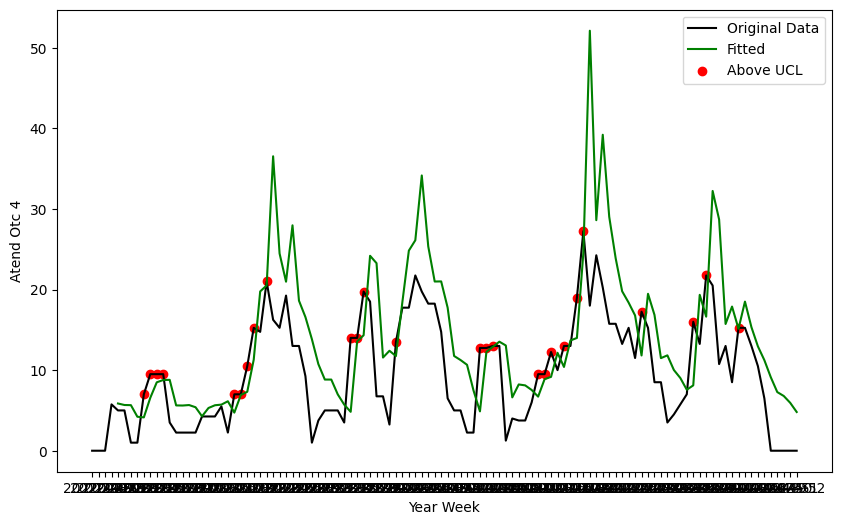

In [16]:
dta = lst_dfs_cities2[0]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(dta.year_week, dta['num_otc_ivas_4'], label='Original Data', color='black')
# Plot the original data
plt.plot(dta.year_week, dta['UCL_otc_only'], label='Fitted', color='green')

# Create boolean masks for points outside limits
out_of_limits_above = dta['num_otc_ivas_4'] >= dta['UCL_otc_only']
out_of_limits_below = dta['num_otc_ivas_4'] < dta['LCL_otc_only']

# Scatter plot for points above UCL
plt.scatter(
    dta['year_week'][out_of_limits_above],  # Ensure the index aligns
    dta['num_otc_ivas_4'][out_of_limits_above],  # Use the same DataFrame
    color='red',
    label='Above UCL'
)

# Optional: Scatter plot for points below LCL
#plt.scatter(
#    dta['year_week'][out_of_limits_below],
#    dta['atend_ivas_4'][out_of_limits_below],
#   color='blue',
#    label='Below LCL'
#)

# Add labels and legend
plt.xlabel('Year Week')
plt.ylabel('Atend Otc 4')
plt.legend()
plt.show()


### Cities without trend and with sezonality

In [17]:
# select cities without trend and sezonality in PHC

df3 = df[(df.p_value_otc_negbi_friedman < 0.05) & (df.p_values_negbi_num_otc_ivas_4 >= 0.05)]

print('number of city without trend and with sezonality', df3.co_ibge.nunique(), 'percentage', round(df3.co_ibge.nunique()*100/5570,1) )

number of city without trend and with sezonality 1385 percentage 24.9


In [18]:
lst_dfs_cities3 = []

for code in df3.co_ibge.unique():
    
    set_muni = df3[df3.co_ibge == code]

    lst_dfs_cities3.append(set_muni)

lst_dfs_cities3 = early_warning_detection_functions.harmonic(lst_dfs_cities3, 'num_otc_ivas_4')

Skipping DataFrame due to yf_filtered_best being None 172000


/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

Skipping DataFrame due to yf_filtered_best being None 220194


/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

Skipping DataFrame due to yf_filtered_best being None 520940


/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

Skipping DataFrame due to yf_filtered_best being None 172130


/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Skipping DataFrame due to yf_filtered_best being None 220630
Skipping DataFrame due to yf_filtered_best being None 171865


/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

Skipping DataFrame due to yf_filtered_best being None 354085


/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

Skipping DataFrame due to yf_filtered_best being None 220554


/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

Skipping DataFrame due to yf_filtered_best being None 420475


/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

Skipping DataFrame due to yf_filtered_best being None 431123


/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

In [19]:
lags_y = range(1, 4)  # Example: Using lags 1 to 4 for y_t
lags_x = range(0, 4)  # Example: Using lags 0 to 4 for x_t
dependent_variable = 'num_otc_ivas_4'  # Example dependent variable

def lags_comb(variable, lags_variable):
    """Create cumulative lag combinations for a given variable."""
    lags_variable_comb = [f'{variable}_{lag}' for lag in lags_variable]
    cumulative_sums_var = [' + '.join(lags_variable_comb[:i]) for i in range(1, len(lags_variable_comb) + 1)]
    return cumulative_sums_var

# Generate lagged combinations
lags_y_comb = lags_comb('otc_4_lag', lags_y)
lags_x_comb = lags_comb('phc_4_lag', lags_x)

formulas = []

# Iterate over all combinations and create formula strings
for value in lags_x_comb:
    for terms in lags_y_comb:
        components = [terms, value]
        # Remove empty strings and join components
        formula_components = 'Reconstructed + ' + ' + '.join(filter(None, components))
        formula = f'{dependent_variable} ~ {formula_components}'
        formulas.append(formula)

In [20]:
## Keep the best model formulas and AIC
lst = []

for data in lst_dfs_cities3:
    print(f"Processing {data.co_ibge.iloc[0]}...")

    #data = df3[df3.co_ibge == code].copy()
    #data = data.assign(time_trend=np.arange(len(data)))

    # Initialize placeholders
    best_model = None
    best_aic = float('inf')
    best_formula = np.nan  # Set default as NaN

    # Try fitting models
    for formula in formulas:
        try:
            model = smf.glm(formula=formula, data=data, family=sm.families.NegativeBinomial(alpha=1)).fit()
            current_aic = model.aic

            if current_aic < best_aic:
                best_aic = current_aic
                best_model = model
                best_formula = formula

        except Exception as e:
            print(f"Skipping formula {formula} for {code}: {e}")
            continue  # Skip to the next formula

    # Assign best formula and AIC (or NaN if model failed)
    data = data.assign(best_formula=best_formula, best_aic=best_aic if best_aic != float('inf') else np.nan)
    lst.append(data)

lst_dfs_cities3 = lst  # Store results


#### Save predicted values, upper bound, and warning columns

lst = []

for data in lst_dfs_cities3:
    
    if pd.isna(data.best_formula.iloc[0]):
        # If no valid model, create NaN columns
        data = data.assign(
                fitted_values_otc_only=np.nan,
                residuals_otc_only=np.nan,
                sigma_otc_only=np.nan,
                sigma__otc_only=np.nan,
                sigma_t_otc_only=np.nan
            )
    else:
        # Fit the model and calculate residuals
        model = smf.glm(formula=data.best_formula.iloc[0], data=data, family=sm.families.NegativeBinomial(alpha=1)).fit()
        fitted_values = model.fittedvalues
        residuals = model.resid_deviance

        # Calculate sigmas
        sigma = np.std(residuals)
        sigma_ = np.std(fitted_values)
        sigma_t = fitted_values.rolling(window=5).std()

        # Assign values
        data = data.assign(
                fitted_values_otc_only=fitted_values,
                residuals_otc_only=residuals,
                sigma_otc_only=sigma,
                sigma__otc_only=sigma_,
                sigma_t_otc_only=sigma_t
            )

    lst.append(data)

lst_dfs_cities3 = lst  # Store results

### Control limits and out-of-limits detection

lst = []

for data in lst_dfs_cities3:
    
    if data['fitted_values_otc_only'].isna().all():
        # If no valid fitted values, assign NaNs
        data = data.assign(
                    UCL_otc_only=np.nan,
                    LCL_otc_only=np.nan,
                    out_of_limits_above_otc_only=np.nan,
                    out_of_limits_below_otc_only=np.nan
            )
    else:
        w = 1  # Default weight
        
        UCL_otc_only = data.fitted_values_otc_only + w * data.sigma_t_otc_only
        LCL_otc_only = data.fitted_values_otc_only - w * data.sigma_t_otc_only
        
        data = data.assign(
                UCL_otc_only =  UCL_otc_only,
                LCL_otc_only =  LCL_otc_only,
                out_of_limits_above_otc_only = (data['num_otc_ivas_4'] >= UCL_otc_only).astype(int),
                out_of_limits_below_otc_only=(data['num_otc_ivas_4'] < LCL_otc_only).astype(int)
            )

    lst.append(data)

lst_dfs_cities3 = lst  # Store final results


Processing 171620...
Processing 210630...
Processing 210670...
Processing 210690...
Processing 230320...
Processing 240490...
Processing 241020...
Processing 250650...
Processing 250960...
Processing 251203...
Processing 251700...
Processing 260750...
Processing 270620...
Processing 290600...
Processing 291075...
Processing 291330...
Processing 292805...
Processing 310010...
Processing 310070...
Processing 310170...
Processing 310230...
Processing 310510...
Processing 311040...
Processing 314670...
Processing 315670...
Processing 315900...
Processing 316170...
Processing 316720...
Processing 317050...
Processing 320010...
Processing 320030...
Processing 320400...
Processing 350760...
Processing 350870...
Processing 350900...
Processing 350910...
Processing 351110...
Processing 351390...
Processing 352220...
Processing 353950...
Processing 354323...
Processing 354470...
Processing 354750...
Processing 354765...
Processing 355610...
Processing 410140...
Processing 410870...
Processing 41

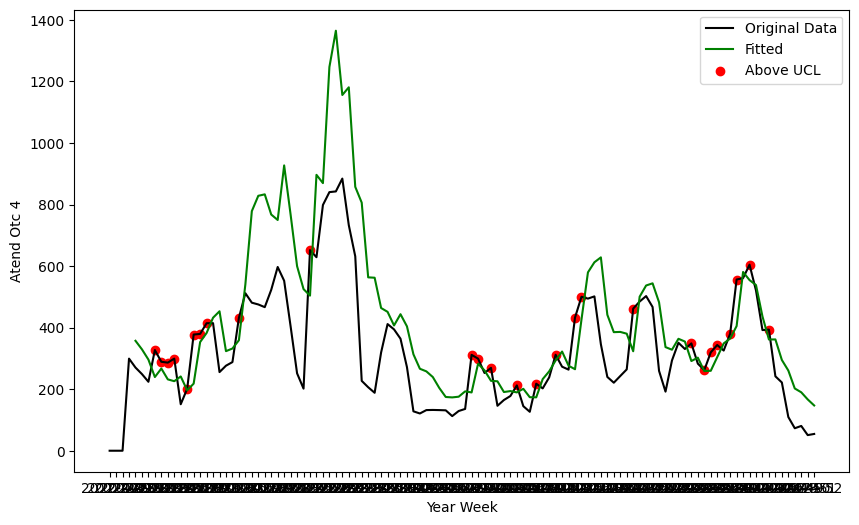

In [21]:
dta = lst_dfs_cities3[4]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(dta.year_week, dta['num_otc_ivas_4'], label='Original Data', color='black')
# Plot the original data
plt.plot(dta.year_week, dta['UCL_otc_only'], label='Fitted', color='green')

# Create boolean masks for points outside limits
out_of_limits_above = dta['num_otc_ivas_4'] >= dta['UCL_otc_only']
out_of_limits_below = dta['num_otc_ivas_4'] < dta['LCL_otc_only']

# Scatter plot for points above UCL
plt.scatter(
    dta['year_week'][out_of_limits_above],  # Ensure the index aligns
    dta['num_otc_ivas_4'][out_of_limits_above],  # Use the same DataFrame
    color='red',
    label='Above UCL'
)

# Optional: Scatter plot for points below LCL
#plt.scatter(
#    dta['year_week'][out_of_limits_below],
#    dta['atend_ivas_4'][out_of_limits_below],
#   color='blue',
#    label='Below LCL'
#)

# Add labels and legend
plt.xlabel('Year Week')
plt.ylabel('Atend Otc 4')
plt.legend()
plt.show()


### Cities with trend and with sezonality

In [23]:
# select cities without trend and sezonality in PHC

df4 = df[(df.p_value_otc_negbi_friedman < 0.05) & (df.p_values_negbi_num_otc_ivas_4 < 0.05)]

print('number of city with trend and sezonality', df4.co_ibge.nunique(), 'percentage', round(df4.co_ibge.nunique()*100/5570,1) )

number of city with trend and sezonality 379 percentage 6.8


In [24]:
lst_dfs_cities4 = []

for code in df4.co_ibge.unique():
    
    set_muni = df4[df4.co_ibge == code]

    lst_dfs_cities4.append(set_muni)

lst_dfs_cities4 = early_warning_detection_functions.harmonic(lst_dfs_cities4, 'num_otc_ivas_4')

/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

Skipping DataFrame due to yf_filtered_best being None 172049
Skipping DataFrame due to yf_filtered_best being None 520350


/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

Skipping DataFrame due to yf_filtered_best being None 316080
Skipping DataFrame due to yf_filtered_best being None 170980
Skipping DataFrame due to yf_filtered_best being None 220987
Skipping DataFrame due to yf_filtered_best being None 314360
Skipping DataFrame due to yf_filtered_best being None 316580


/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

Skipping DataFrame due to yf_filtered_best being None 311360
Skipping DataFrame due to yf_filtered_best being None 280260


/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

Skipping DataFrame due to yf_filtered_best being None 315940


/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

Skipping DataFrame due to yf_filtered_best being None 240120


/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

In [25]:
lags_y = range(1, 4)  # Example: Using lags 1 to 4 for y_t
lags_x = range(0, 4)  # Example: Using lags 0 to 4 for x_t
dependent_variable = 'num_otc_ivas_4'  # Example dependent variable

def lags_comb(variable, lags_variable):
    """Create cumulative lag combinations for a given variable."""
    lags_variable_comb = [f'{variable}_{lag}' for lag in lags_variable]
    cumulative_sums_var = [' + '.join(lags_variable_comb[:i]) for i in range(1, len(lags_variable_comb) + 1)]
    return cumulative_sums_var

# Generate lagged combinations
lags_y_comb = lags_comb('otc_4_lag', lags_y)
lags_x_comb = lags_comb('phc_4_lag', lags_x)

formulas = []

# Iterate over all combinations and create formula strings
for value in lags_x_comb:
    for terms in lags_y_comb:
        components = [terms, value]
        # Remove empty strings and join components
        formula_components = 'time_trend + Reconstructed + ' + ' + '.join(filter(None, components))
        formula = f'{dependent_variable} ~ {formula_components}'
        formulas.append(formula)

In [26]:
## Keep the best model formulas and AIC
lst = []

for data in lst_dfs_cities4:
    print(f"Processing {data.co_ibge.iloc[0]}...")

    #data = df3[df3.co_ibge == code].copy()
    data = data.assign(time_trend=np.arange(len(data)))

    # Initialize placeholders
    best_model = None
    best_aic = float('inf')
    best_formula = np.nan  # Set default as NaN

    # Try fitting models
    for formula in formulas:
        try:
            model = smf.glm(formula=formula, data=data, family=sm.families.NegativeBinomial(alpha=1)).fit()
            current_aic = model.aic

            if current_aic < best_aic:
                best_aic = current_aic
                best_model = model
                best_formula = formula

        except Exception as e:
            print(f"Skipping formula {formula} for {code}: {e}")
            continue  # Skip to the next formula

    # Assign best formula and AIC (or NaN if model failed)
    data = data.assign(best_formula=best_formula, best_aic=best_aic if best_aic != float('inf') else np.nan)
    lst.append(data)

lst_dfs_cities4 = lst  # Store results


Processing 210927...
Processing 221065...
Processing 230010...
Processing 250135...
Processing 320503...
Processing 353330...
Processing 420130...
Processing 420330...
Processing 421205...
Processing 421380...
Processing 430390...
Processing 500440...
Processing 210080...
Processing 230020...
Processing 260340...
Processing 315340...
Processing 316130...
Skipping formula num_otc_ivas_4 ~ time_trend + Reconstructed + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 for 431570: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + Reconstructed + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 431570: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + Reconstructed + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 431570: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + Reconstructed

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Processing 410645...
Processing 412040...
Processing 420470...
Processing 430468...
Processing 431120...
Processing 240210...
Processing 240790...
Processing 310163...
Processing 312240...
Processing 350240...
Processing 412065...
Processing 420775...
Processing 130020...
Processing 220360...
Processing 240615...
Processing 250500...
Processing 291690...
Processing 317060...
Processing 330411...
Processing 411440...
Processing 421640...
Processing 430637...
Processing 430810...
Processing 430920...
Processing 432180...
Processing 110060...
Processing 150034...
Processing 241100...
Processing 250435...
Processing 290130...
Processing 314000...
Skipping formula num_otc_ivas_4 ~ time_trend + Reconstructed + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 431570: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + Reconstructed + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 431570: NaN, inf or invalid value detected 

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/p

Skipping formula num_otc_ivas_4 ~ time_trend + Reconstructed + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 431570: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + Reconstructed + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 431570: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + Reconstructed + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 431570: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + Reconstructed + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 431570: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + Reconstructed + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.en

Processing 220552...
Processing 220558...
Processing 240540...
Processing 241200...
Processing 292140...
Processing 311780...
Processing 315445...
Processing 352850...
Processing 352965...
Processing 354540...
Processing 430040...
Processing 430692...
Processing 431880...
Processing 432232...
Processing 432360...
Processing 510785...
Processing 220672...
Processing 290740...
Processing 310780...
Processing 311470...
Processing 311920...
Processing 313590...
Processing 355495...
Processing 420250...
Processing 430960...
Processing 431150...
Processing 432170...
Processing 432240...
Processing 510645...
Processing 520840...
Processing 520960...
Processing 130010...
Processing 241030...
Processing 291370...
Processing 313862...
Processing 320016...
Processing 352300...
Processing 353680...
Processing 430120...
Processing 430130...
Processing 430200...
Processing 431130...
Processing 431450...
Processing 431842...
Processing 431848...
Processing 432120...
Skipping formula num_otc_ivas_4 ~ 

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/st

Processing 210880...
Processing 220273...
Processing 260915...
Processing 311310...
Processing 312300...
Processing 313850...
Processing 316255...
Processing 316670...
Processing 352360...
Processing 412160...
Skipping formula num_otc_ivas_4 ~ time_trend + Reconstructed + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 for 431570: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + Reconstructed + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 431570: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + Reconstructed + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 431570: NaN, inf or invalid value detected in weights, estimation infeasible.


/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/p

Skipping formula num_otc_ivas_4 ~ time_trend + Reconstructed + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 + phc_4_lag_3 for 431570: NaN, inf or invalid value detected in weights, estimation infeasible.
Processing 420920...
Processing 430030...
Processing 430850...
Processing 431449...
Processing 431480...
Processing 431900...
Processing 130165...
Processing 210360...
Processing 290460...
Processing 313740...
Processing 315057...
Processing 316990...
Processing 350430...
Processing 350850...
Processing 420519...
Processing 430640...
Processing 521690...
Processing 150130...
Processing 210632...
Processing 211010...
Processing 220245...
Processing 231195...
Processing 292490...
Processing 292850...
Processing 314610...
Processing 315030...
Processing 316740...
Processing 351150...
Processing 351730...
Processing 355480...
Processing 410650...
Processing 420580...
Processing 421568...
Processing 421569...
Processing 430280...
Processing 430490...
Pro

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
/home/juliane.oliveira/.local/lib/python3.10/site-packages

Processing 420455...
Processing 420690...
Processing 430003...
Processing 430885...
Processing 431000...
Processing 431265...
Processing 431295...
Processing 431410...
Processing 432090...
Processing 500070...
Processing 500627...
Processing 220342...
Processing 220390...
Skipping formula num_otc_ivas_4 ~ time_trend + Reconstructed + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 for 431570: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + Reconstructed + otc_4_lag_1 + otc_4_lag_2 + phc_4_lag_0 + phc_4_lag_1 for 431570: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + Reconstructed + otc_4_lag_1 + otc_4_lag_2 + otc_4_lag_3 + phc_4_lag_0 + phc_4_lag_1 for 431570: NaN, inf or invalid value detected in weights, estimation infeasible.
Skipping formula num_otc_ivas_4 ~ time_trend + Reconstructed + otc_4_lag_1 + phc_4_lag_0 + phc_4_lag_1 + phc_4_lag_2 for 431570: N

/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: overflow encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/home/juliane.oliveira/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/juliane.oliveira/.local/lib/python3.10/site-p

Processing 293120...
Processing 293230...
Processing 313340...
Processing 314315...
Processing 315530...
Processing 316140...
Processing 316330...
Processing 351080...
Processing 351170...
Processing 351950...
Processing 352265...
Processing 353657...
Processing 410322...
Processing 431160...
Processing 431445...
Processing 431570...


In [27]:
#### Save predicted values, upper bound, and warning columns

lst = []

for data in lst_dfs_cities4:
    
    if pd.isna(data.best_formula.iloc[0]):
        # If no valid model, create NaN columns
        data = data.assign(
                fitted_values_otc_only=np.nan,
                residuals_otc_only=np.nan,
                sigma_otc_only=np.nan,
                sigma__otc_only=np.nan,
                sigma_t_otc_only=np.nan
            )
    else:
        # Fit the model and calculate residuals
        model = smf.glm(formula=data.best_formula.iloc[0], data=data, family=sm.families.NegativeBinomial(alpha=1)).fit()
        fitted_values = model.fittedvalues
        residuals = model.resid_deviance

        # Calculate sigmas
        sigma = np.std(residuals)
        sigma_ = np.std(fitted_values)
        sigma_t = fitted_values.rolling(window=5).std()

        # Assign values
        data = data.assign(
                fitted_values_otc_only=fitted_values,
                residuals_otc_only=residuals,
                sigma_otc_only=sigma,
                sigma__otc_only=sigma_,
                sigma_t_otc_only=sigma_t
            )

    lst.append(data)

lst_dfs_cities4 = lst  # Store results


In [28]:
### Control limits and out-of-limits detection

lst = []

for data in lst_dfs_cities4:
    
    if data['fitted_values_otc_only'].isna().all():
        # If no valid fitted values, assign NaNs
        data = data.assign(
                    UCL_otc_only=np.nan,
                    LCL_otc_only=np.nan,
                    out_of_limits_above_otc_only=np.nan,
                    out_of_limits_below_otc_only=np.nan
            )
    else:
        w = 1  # Default weight
        
        UCL_otc_only = data.fitted_values_otc_only + w * data.sigma_t_otc_only
        LCL_otc_only = data.fitted_values_otc_only - w * data.sigma_t_otc_only
        
        data = data.assign(
                UCL_otc_only =  UCL_otc_only,
                LCL_otc_only =  LCL_otc_only,
                out_of_limits_above_otc_only = (data['num_otc_ivas_4'] >= UCL_otc_only).astype(int),
                out_of_limits_below_otc_only=(data['num_otc_ivas_4'] < LCL_otc_only).astype(int)
            )

    lst.append(data)

lst_dfs_cities4 = lst  # Store final results


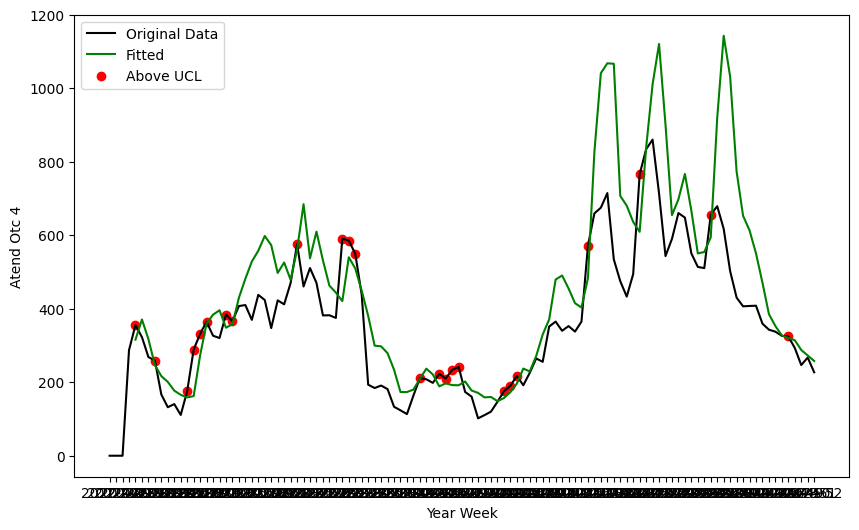

In [29]:
dta = lst_dfs_cities4[4]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(dta.year_week, dta['num_otc_ivas_4'], label='Original Data', color='black')
# Plot the original data
plt.plot(dta.year_week, dta['UCL_otc_only'], label='Fitted', color='green')

# Create boolean masks for points outside limits
out_of_limits_above = dta['num_otc_ivas_4'] >= dta['UCL_otc_only']
out_of_limits_below = dta['num_otc_ivas_4'] < dta['LCL_otc_only']

# Scatter plot for points above UCL
plt.scatter(
    dta['year_week'][out_of_limits_above],  # Ensure the index aligns
    dta['num_otc_ivas_4'][out_of_limits_above],  # Use the same DataFrame
    color='red',
    label='Above UCL'
)

# Optional: Scatter plot for points below LCL
#plt.scatter(
#    dta['year_week'][out_of_limits_below],
#    dta['atend_ivas_4'][out_of_limits_below],
#   color='blue',
#    label='Below LCL'
#)

# Add labels and legend
plt.xlabel('Year Week')
plt.ylabel('Atend Otc 4')
plt.legend()
plt.show()


# Process and save data

In [30]:
len(lst_dfs_cities1) + len(lst_dfs_cities2) + len(lst_dfs_cities3) + len(lst_dfs_cities4)

5511

In [31]:
lst_dfs_cities1[0].columns

Index(['sigla_uf', 'co_uf', 'nm_uf', 'co_ibge7', 'nm_municipio', 'co_ibge',
       'year_week', 'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end',
       'atend_ivas', 'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4',
       'dtrend_ivas_negbi', 'dtrend_otc_negbi', 'p_values_negbi_atend_ivas_4',
       'p_values_negbi_num_otc_ivas_4', 'p_value_ivas_negbi_friedman',
       'p_value_otc_negbi_friedman', 'phc_4_lag_1', 'phc_4_lag_2',
       'phc_4_lag_3', 'otc_4_lag_1', 'otc_4_lag_2', 'otc_4_lag_3',
       'phc_4_lag_0', 'otc_4_lag_0', 'best_formula', 'best_aic',
       'fitted_values_otc_only', 'residuals_otc_only', 'sigma_otc_only',
       'sigma__otc_only', 'sigma_t_otc_only', 'UCL_otc_only', 'LCL_otc_only',
       'out_of_limits_above_otc_only', 'out_of_limits_below_otc_only'],
      dtype='object')

In [32]:
lst1 = []

for data in lst_dfs_cities1:

    data = data[['nm_uf', 'co_ibge7', 'nm_municipio', 'co_ibge',
                 'year_week', 'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end',
                 'atend_ivas', 'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4',
                 'best_formula', 'best_aic', 'fitted_values_otc_only',
                 'residuals_otc_only', 'UCL_otc_only', 'LCL_otc_only',
                 'out_of_limits_above_otc_only', 'out_of_limits_below_otc_only']]

    lst1.append(data)


for data in lst_dfs_cities2:

    data = data[['nm_uf', 'co_ibge7', 'nm_municipio', 'co_ibge',
                 'year_week', 'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end',
                 'atend_ivas', 'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4',
                 'best_formula', 'best_aic', 'fitted_values_otc_only',
                 'residuals_otc_only', 'UCL_otc_only', 'LCL_otc_only',
                 'out_of_limits_above_otc_only', 'out_of_limits_below_otc_only']]

    lst1.append(data)

for data in lst_dfs_cities3:

    data = data[['nm_uf', 'co_ibge7', 'nm_municipio', 'co_ibge',
                 'year_week', 'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end',
                 'atend_ivas', 'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4',
                 'best_formula', 'best_aic', 'fitted_values_otc_only',
                 'residuals_otc_only', 'UCL_otc_only', 'LCL_otc_only',
                 'out_of_limits_above_otc_only', 'out_of_limits_below_otc_only']]

    lst1.append(data)

for data in lst_dfs_cities4:

    data = data[['nm_uf', 'co_ibge7', 'nm_municipio', 'co_ibge',
                 'year_week', 'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end',
                 'atend_ivas', 'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4',
                 'best_formula', 'best_aic', 'fitted_values_otc_only',
                 'residuals_otc_only', 'UCL_otc_only', 'LCL_otc_only',
                 'out_of_limits_above_otc_only', 'out_of_limits_below_otc_only']]

    lst1.append(data)

In [33]:
final = pd.concat(lst1)

In [34]:
final = final.rename(columns = { 'fitted_values_otc_only': 'fitted_values_otc_with_aps', 
                                 'residuals_otc_only': 'residuals_otc_with_aps',
                                 'UCL_otc_only': 'UCL_otc_with_aps',
                                 'LCL_otc_only': 'LCL_otc_with_aps', 
                                 'out_of_limits_above_otc_only': 'out_of_limits_above_otc_with_aps',
                                 'out_of_limits_below_otc_only': 'out_of_limits_below_otc_with_aps'})

In [35]:
final.columns

Index(['nm_uf', 'co_ibge7', 'nm_municipio', 'co_ibge', 'year_week',
       'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end', 'atend_ivas',
       'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4', 'best_formula',
       'best_aic', 'fitted_values_otc_with_aps', 'residuals_otc_with_aps',
       'UCL_otc_with_aps', 'LCL_otc_with_aps',
       'out_of_limits_above_otc_with_aps', 'out_of_limits_below_otc_with_aps'],
      dtype='object')

In [36]:
final.to_parquet('/home/juliane.oliveira/workspace/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_otc_with_aps_muni.parquet')

